# Build graph from dataframe
In this notebook, we execute the k-NN algorithm to build a graph from an initial dataframe. In the k-NN algorithm, each node is connected to its k nearest neighbors.

In [1]:
import pandas as pd
import numpy as np
from models.BuildGraph import BuildGraph
from utils.preProcessing import preProcessing

In [2]:
preprocessor = preProcessing()

## 1. Reading dataset

In [3]:
df = pd.read_excel('data/Supplemental-table1.xlsx')
df = df.loc[df["Cohort"] == "Naive"]
df

,Anonymous ID,EGA ID,Tumour type,Sex,Line of therapy,Immunotherapy regimen,Cohort,Reason for discontinuation,Best response,Age at advanced disease diagnosis,...,Alive_0,Time to progression (days),Progression_1,Clinical benefit,CD8+ T cell score,Exome mut per mb,Genome mut per mb,CD274 expression,M1M2 expression,Lymph related
0,14891,EGAD00001001961,LUNG,F,8,Nivolumab,Naive,Progression,Mixed,45,...,1,179,1,NCB,0.351869,11.095310,23.0729,4.1689,55.51575,Non-lymph related
1,18624,EGAD00001002047,AECA,F,10,Nivolumab,Naive,Progression,Stable disease,47,...,1,148,1,NCB,0.071464,3.876336,5.4552,0.7910,9.32352,Non-lymph related
2,21392,EGAD00001002544,OV,F,6,Monalizumab,Naive,Progression,Physician assessed SD,57,...,1,79,1,NCB,0.040394,2.415688,4.1274,4.0377,50.12008,Lymph related
3,21516,EGAD00001002546,SKCM,F,3,Ipilimumab,Naive,Death,Not evaluable,29,...,1,11,0,NCB,0.052774,6.235845,11.4871,0.6006,1.58550,Non-lymph related
4,22186,EGAD00001001966,LUNG,F,4,Atezolizumab,Naive,Progression,Stable disease,52,...,1,80,1,NCB,0.009323,4.606660,7.1503,1.8234,38.42695,Non-lymph related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,39280,EGAD00001004933,LUNG,M,2,Pembrolizumab,Naive,Toxicity,Physician Assessed SD,60,...,1,401,0,DCB,0.695396,84.998501,96.4079,8.4768,86.62561,Non-lymph related
94,37899,EGAD00001005838,CHOL,F,2,Nivolumab,Naive,Death,Physician assessed PR,38,...,1,96,0,NCB,0.818233,2.247151,2.7416,11.2704,47.97376,Non-lymph related
95,37775,EGAD00001004934,HNSC,M,1,Avelumab/OX40 agonist PF-04518600,Naive,Progression,Stable disease,69,...,1,69,1,NCB,0.018982,3.848247,5.8036,8.7136,5.13403,Non-lymph related
96,38313,EGAD00001005844,ACC,F,3,Avelumab/Debio1143 (SMAC mimetic),Naive,Toxicity,Partial response,34,...,1,51,1,NCB,0.000000,5.617878,7.7940,0.0688,0.51364,Non-lymph related


## 2. Find nearest patients
The useful features to evaluate patients similarity are :
- Tumour type
- Sex
- Immunotherapy regimen
- Age
- CD8+ T cell score
- M1M2 expression score
- Genome mut per mb
- Exome mut per mb
- CD274 expression

Some of these features are categorical, so we need to numerize them.

### a. Numerize categorical features and normalization

In [4]:
df_numerized = pd.get_dummies(df.loc[:,["Tumour type","Sex","Immunotherapy regimen","Age at advanced disease diagnosis","CD8+ T cell score","M1M2 expression","Genome mut per mb","Exome mut per mb","CD274 expression"]]).astype(float)
#df_numerized = pd.get_dummies(df.loc[:,["Tumour type"]]).astype(float)
X_numerized = preprocessor.normalize_data(df_numerized.to_numpy())

### b. Build graph - euclidean distance and k=10 neighbors
Here, we use the euclidean distance to compare patients, and we connect each node to its 10 nearest patients.

In [5]:
buildgraph = BuildGraph()

In [6]:
A = buildgraph.apply_knn(X_numerized, k=10, metric="euclidean")

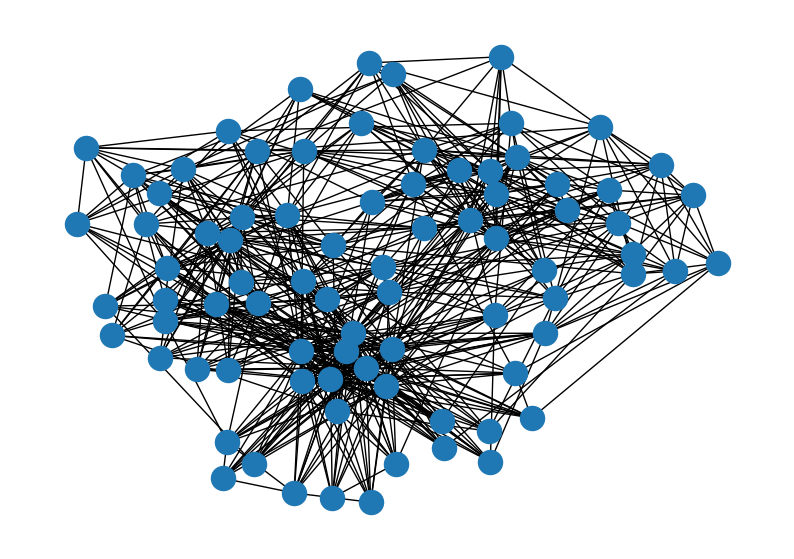

In [7]:
# Vizualize the graph
buildgraph.show_graph(A)

## 3. Evaluate neighbors similarity
Now, we want to evaluate if 2 patients which are considered as neighbors have some important features in common.

### a. Tumour type

In [8]:
tumour_similarity = buildgraph.proportion_similarity_neighbors(A, df["Tumour type"].to_numpy())
print(f"{tumour_similarity*100} % of neighbor patients have the same tumour type.")

49.0 % of neighbor patients have the same tumour type.


### b. Age

## 3. Split per tumour type

In [9]:
tumour_types = np.unique(df["Tumour type"].to_numpy())
dico_tumour = {} #clé : tumour type, value = df_associated
for i in range(tumour_types.shape[0]):
    dico_tumour[tumour_types[i]] = df.loc[df["Tumour type"] == tumour_types[i]]

In [10]:
dico_tumour

{'ACC':     Anonymous ID           EGA ID Tumour type Sex Line of therapy   
 33         28123  EGAD00001003065         ACC   M               2  \
 96         38313  EGAD00001005844         ACC   F               3   
 
                 Immunotherapy regimen Cohort Reason for discontinuation   
 33           Tremelimumab, Durvalumab  Naive                Progression  \
 96  Avelumab/Debio1143 (SMAC mimetic)  Naive                   Toxicity   
 
           Best response  Age at advanced disease diagnosis  ...  Alive_0   
 33  Progressive disease                                 40  ...        0  \
 96     Partial response                                 34  ...        1   
 
     Time to progression (days)  Progression_1  Clinical benefit   
 33                         107              1               NCB  \
 96                          51              1               NCB   
 
    CD8+ T cell score  Exome mut per mb  Genome mut per mb  CD274 expression   
 33          0.068854          0

In [11]:
# tab index stocke les index, car pour la matrice d'adjacence, on doit conserver l'ordre des index
dico_index = {}
index = 0
for key in list(dico_tumour.keys()):
    dico_index[key] = [k for k in range(index,index+dico_tumour[key].shape[0])]
    index += dico_tumour[key].shape[0]
dico_index

{'ACC': [0, 1],
 'AECA': [2, 3],
 'BRCA': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 'CHOL': [16, 17, 18],
 'COLO': [19, 20, 21, 22, 23, 24],
 'ESCA': [25],
 'GCT': [26],
 'HNSC': [27, 28, 29, 30],
 'KDNY': [31, 32],
 'LUNG': [33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57],
 'LYMP': [58],
 'OV': [59],
 'PANC': [60, 61],
 'SARC': [62, 63, 64, 65, 66],
 'SKCM': [67, 68, 69, 70, 71, 72, 73],
 'STAD': [74, 75],
 'THYM': [76],
 'UCEC': [77, 78, 79],
 'UVM': [80, 81]}

In [20]:
matrice_adjacence = np.zeros((df.shape[0],df.shape[0]))

index = 0
for tumour in list(dico_tumour.keys()):

    # Pour chaque df de tumeur, on estime la matrice d'adjacence locale
    df_tumour = pd.get_dummies(dico_tumour[tumour].loc[:,["Tumour type","Sex","Immunotherapy regimen","Age at advanced disease diagnosis","CD8+ T cell score","M1M2 expression","Genome mut per mb","Exome mut per mb","CD274 expression"]]).astype(float)
    X_tumour = preprocessor.normalize_data(df_tumour.to_numpy())
    A_tumour = buildgraph.apply_knn(X_tumour, k=2, metric="euclidean")

    # On insère cette matrice d'adjacence locale dans la matrice d'adjacence globale
    for j in range(A_tumour.shape[0]):
        relative_index_1 = np.where(A_tumour[j]==1)[0]
        absolute_index = index + relative_index_1
        matrice_adjacence[j][absolute_index]=1

    index += A_tumour.shape[0]

matrice_adjacence

array([[0., 1., 0., ..., 1., 0., 1.],
       [1., 0., 1., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

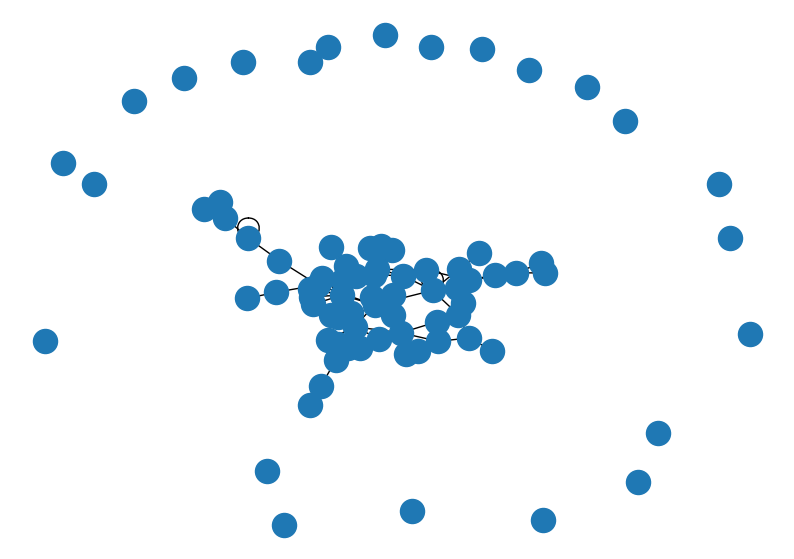

In [21]:
# Vizualize the graph
buildgraph.show_graph(matrice_adjacence)

## 4. Evaluate gathering
We want to check, for each patient, how many patients have the same tumour type, age, treatment...
Typically : "75% des voisins du patient 12 ont la même tumeur que lui" --> En moyenne, 75% des voisins sont de la même tumeur.

In [13]:
# def get_patient_neighbors(row_A):
#     """ 
#     Get index of neighbors of the patient, from the row of the adjacency matrix.
#     """
#     return np.where(row_A == 1)

# def estimate_similarity_tumour(A, tumour_col):
#     """
    
#     """
#     mean_similarity = 0
#     for i in range(A.shape[0]):
#         tumour_i = tumour_col[i]
#         tumour_neighbors = tumour_col[get_patient_neighbors(A[i])]
#         print(tumour_neighbors)
#         print(np.where(tumour_neighbors == tumour_i))
#         similarity_patient_i = np.count_nonzero(np.where(tumour_neighbors == tumour_i)) / tumour_neighbors.shape[0] #-1 car on ne compte pas i-i comme positif
#         mean_similarity += similarity_patient_i
#         print(f"Patient {i} : {similarity_patient_i*100} % des patients voisins ont la même tumeur ({tumour_i})")
#     return mean_similarity/A.shape[0]

In [14]:
# tumour_col = df["Tumour type"].to_numpy()
# similarity_tumour = estimate_similarity_tumour(A, tumour_col)
# print(f"En moyenne, {similarity_tumour*100} % des patients voisins partagent la même tumeur.")